<a href="https://colab.research.google.com/github/StevenHolmberg/CSE5683/blob/main/Active_Shape_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [17]:
!ls
# Define the folder path
filepath = '/content/drive/MyDrive/AdvancedComputerVision/Assignment7_images/shapes'

drive  sample_data


In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri May  8 08:22:50 2020

@author: ms
"""
import os
import matplotlib.image as mpimg

def skip_comments(fp):
    while True:
        last_pos = fp.tell()
        line = fp.readline()
        if not line.strip().startswith('#') and  line.strip():
           break
    fp.seek(last_pos)

def getxy_selective(line):
    points = line.split()
    return [float(points[2]), float(points[3])]

def getxy(line):
    points = line.split()
    return [ float(point) for point in points]

def readPoints(filepath, filename,getxy=getxy):
    with open(os.path.join(filepath,filename)) as fp:
        skip_comments(fp)
        num_points = int(fp.readline())
        skip_comments(fp)
        points = [getxy(fp.readline()) for i in range(num_points)]
    return points

def imgname_from_segfilename(filepath, filename):
    return os.path.join(filepath,filename.split(sep='.')[0]+'.bmp')


def readSegmentations(filepath,getxy = getxy,extension = 'asf'):
    segmentationlist = [ readPoints(filepath,file,getxy) for file in os.listdir(filepath)
                            if file.endswith(extension)]
    return segmentationlist

def getImageWH(filename):
    img = mpimg.imread(filename)
    return img.shape

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri May  8 20:46:34 2020

@author: ms
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate



def interp(points, closed_curve = False,k_=3,s_=0):
    if closed_curve:
        points = np.vstack((points,points[0]))
    tck, u = interpolate.splprep([points[:,0],points[:,1]], k=k_,s=s_)
    if closed_curve:
        u = np.linspace(0,1,num = 150,endpoint = True)
    else:
        u = np.linspace(0,1,num = 150,endpoint = False)
    interp_inner = interpolate.splev(u, tck)
    return interp_inner

def showInterp(interp_points,W=256,H=256,marker = 'r'):
    plt.plot(interp_points[0]*W,interp_points[1]*H,marker)
    plt.axis('off')


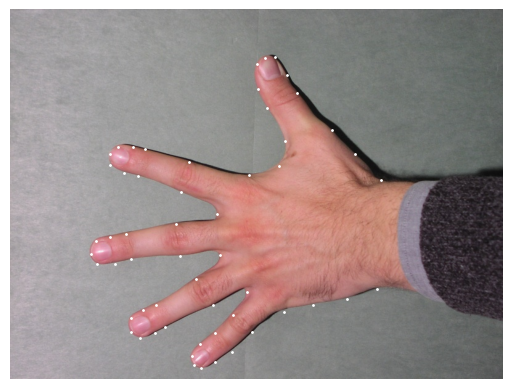

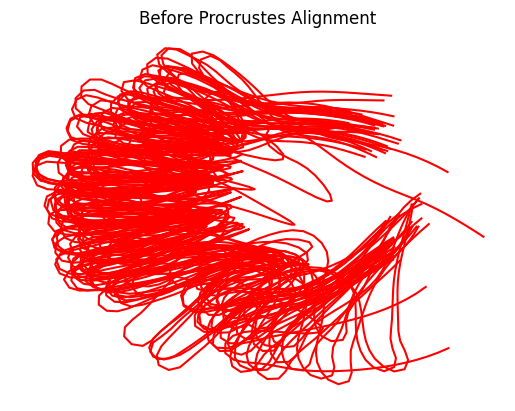

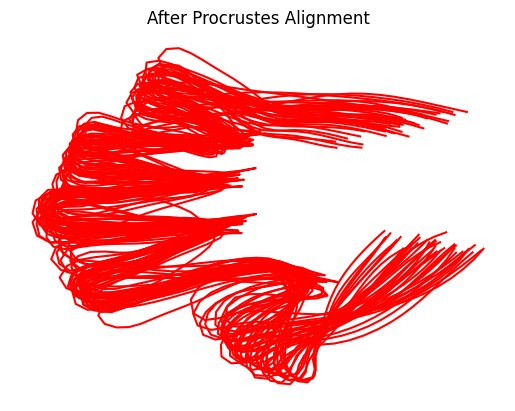

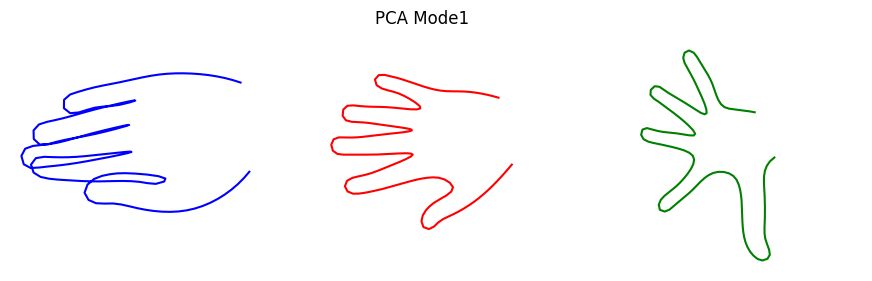

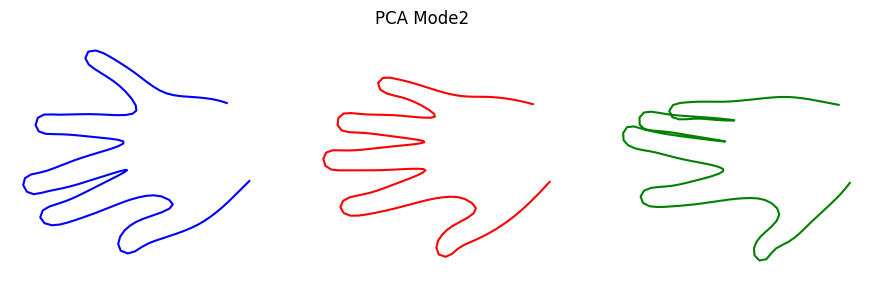

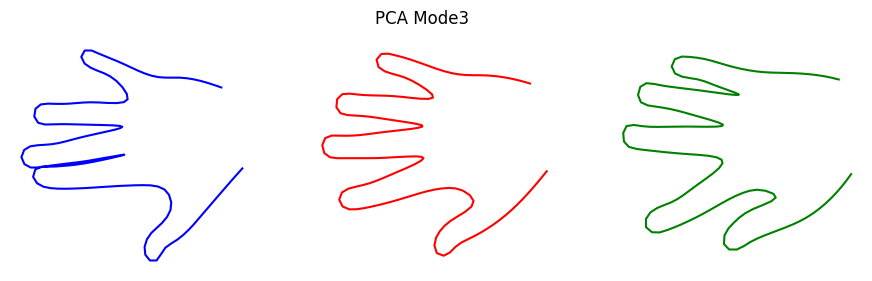

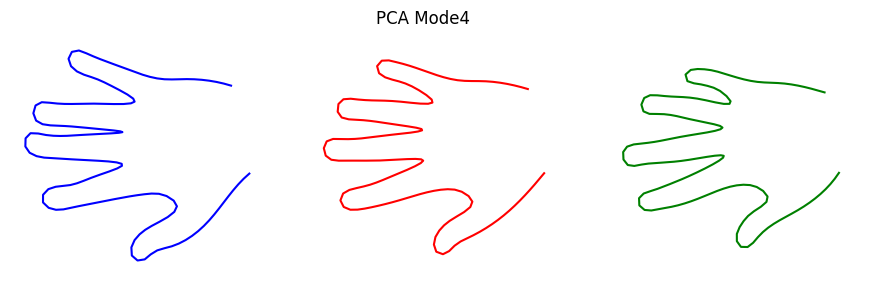

In [19]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu May  7 08:54:23 2020

@author: ms
"""
import os
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# from read_files import *
# from my_interpolate import *

DATASET = 'HAND'

def get_centroids(points):
    """ obtain centroid of LV cardiac dataset which consists of two
    circles each containing 33 points """
    c1 = np.mean(points[:33],axis = 0)
    c2 = np.mean(points[33:],axis = 0)
    return c1,c2

def unmake_1d(hand):
    return np.array([ [hand[i], hand[i+56]] for i in range(0,hand.shape[0]//2)])

def make_1d(hand):
    return np.concatenate((hand[:,0],hand[:,1])).reshape(-1)


def showImg(filename,show = False):
    plt.imshow(mpimg.imread(filename))
    plt.axis('off')
    if show:
        plt.show()



def showPoints(points,W=256,H=256, show = False,color = 'white'):
    points = np.array(points)
    plt.scatter(points[:,0]*W,points[:,1]*H,color=color,s = 1)
    if show:
        plt.show()

def showSegImg(imgpath,points,W = None,H = None):
    if W is  None:
        W,H = getImageWH(imgpath)
    showImg(imgpath)
    if DATASET == 'HAND':
        pass
    else:

        showInterp(interp(points[:33]),W,H)
        showInterp(interp(points[33:]),W,H)
    showPoints(points,W,H,True)


def showCentroids(centroids,W=256,H=256):
    plt.scatter(centroids[:,0,0]*W,centroids[:,0,1]*H,marker = '4',color = 'black')
    plt.scatter(centroids[:,1,0]*W,centroids[:,1,1]*H,marker = '4',color = 'black')
    plt.axis('off')

def showPCAModes(mean_centre, mode ,title = None):
    mean_center_in = mean_centre.reshape(66,-1)[:33]
    mean_center_out = mean_centre.reshape(66,-1)[33:]

    ax1 = plt.subplot(1,2,1)
    showInterp(interp(mean_center_in),marker = 'r')
    showInterp(interp(mean_center_out),marker = 'r')
    showInterp(interp(mean_center_in + mode.reshape(66,-1)[:33]),marker = 'b')
    showInterp(interp(mean_center_out + mode.reshape(66,-1)[:33]),marker = 'b')

    plt.subplot(1,2,2, sharex = ax1,sharey = ax1)
    showInterp(interp(mean_center_in),marker = 'r')
    showInterp(interp(mean_center_out),marker = 'r')
    showInterp(interp(mean_center_in - mode.reshape(66,-1)[33:]),marker = 'g')
    showInterp(interp(mean_center_out - mode.reshape(66,-1)[33:]),marker = 'g')
    if title:
        plt.suptitle(title)

    plt.show()

def procrustes_hand(hands):
    np.testing.assert_equal(make_1d(unmake_1d(hands[0])),hands[0])
    normalized_hands = hands
    old_normalized_hands = hands

    fig = plt.figure()
    for hand in normalized_hands:
        showInterp(interp(unmake_1d(hand)))
    plt.title('Before Procrustes Alignment')
    plt.show()

    for count in range(5):
        mean_hand = np.mean(normalized_hands,axis = 0)
        for i,hand in enumerate(hands):
            _, mtx, disparity = scipy.spatial.procrustes(unmake_1d(mean_hand),
                                                         unmake_1d(hand))
            normalized_hands[i] = make_1d(mtx)


    fig = plt.figure()
    for hand in normalized_hands:
        showInterp(interp(unmake_1d(hand)))
    plt.title('After Procrustes Alignment')
    plt.show()

    return normalized_hands

def main():

    segmentationlist = readSegmentations(filepath,getxy)[0]
    hands = np.array(segmentationlist).T

    showSegImg(os.path.join(filepath,'0000.jpg'),unmake_1d(hands[0]),600,600)

    normalized_hands = procrustes_hand(hands)

    mean_normalized_hand = np.mean(normalized_hands,axis = 0)
    cov_mat = np.cov(normalized_hands.T)
    eig_val, eig_vec = np.linalg.eigh(cov_mat)
    m = unmake_1d(mean_normalized_hand)
    for i in range(1,5):
        modeminus = unmake_1d(eig_vec[:,-i]*-3*np.sqrt(eig_val[-i]))+unmake_1d(mean_normalized_hand)
        modeplus = unmake_1d(eig_vec[:,-i]*3*np.sqrt(eig_val[-i]))+unmake_1d(mean_normalized_hand)
        fig = plt.figure(figsize =(11,3))
        ax1 = plt.subplot(131)
        showInterp(interp(modeminus),marker = 'b')
        plt.subplot(132,sharex = ax1, sharey = ax1)
        showInterp(interp(m))
        plt.subplot(133,sharex = ax1, sharey = ax1)
        showInterp(interp(modeplus),marker = 'g')
        plt.suptitle('PCA Mode' + str(i))
        plt.show()

if __name__ == '__main__':
    main()

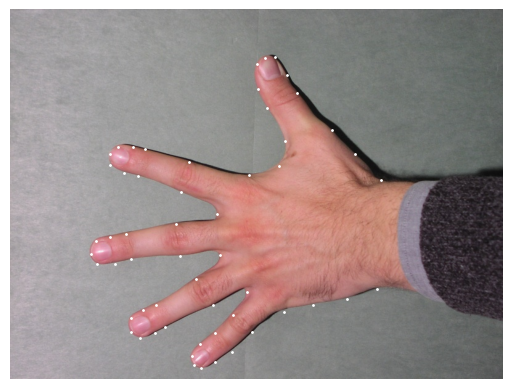

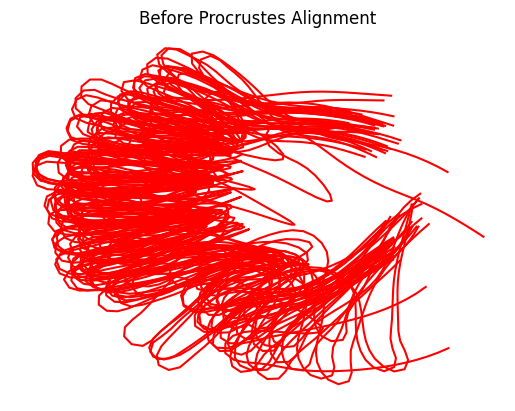

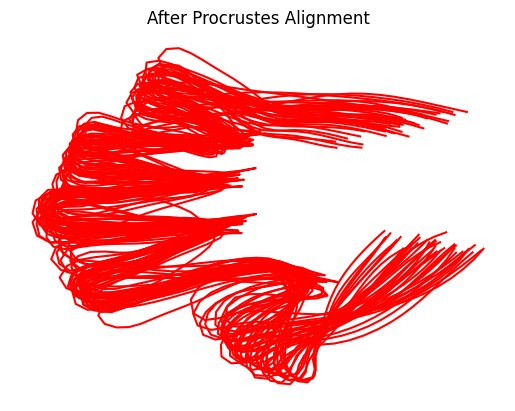

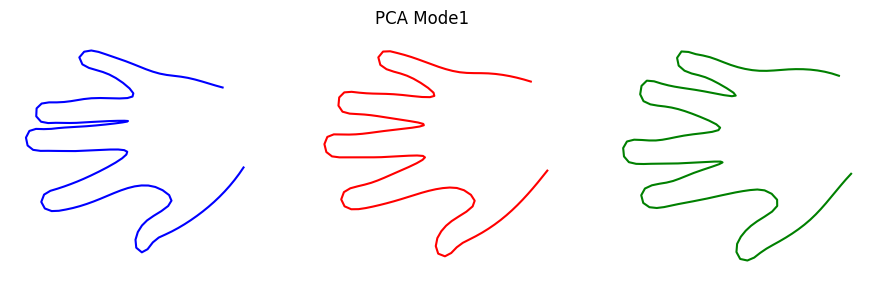

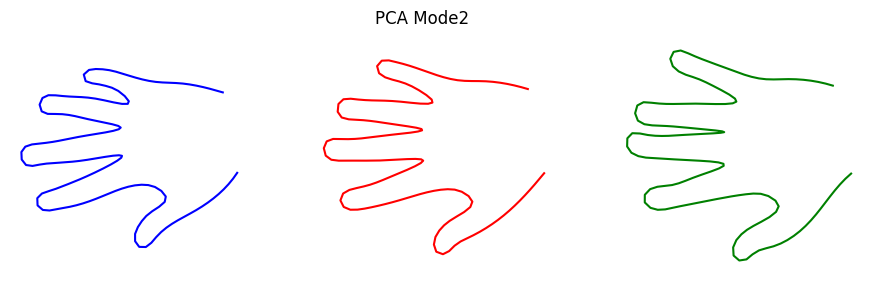

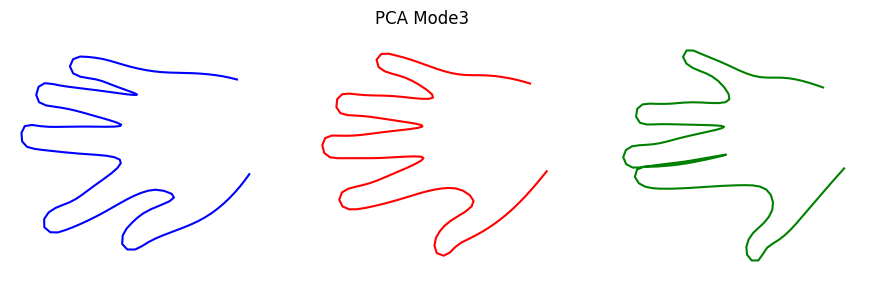

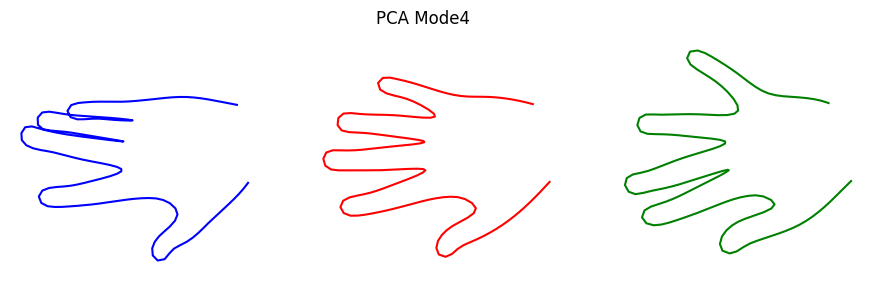

In [22]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu May  7 08:54:23 2020

@author: ms
"""
import os
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA

# from read_files import *
# from my_interpolate import *

DATASET = 'HAND'

def get_centroids(points):
    """ obtain centroid of LV cardiac dataset which consists of two
    circles each containing 33 points """
    c1 = np.mean(points[:33],axis = 0)
    c2 = np.mean(points[33:],axis = 0)
    return c1,c2

def unmake_1d(hand):
    return np.array([ [hand[i], hand[i+56]] for i in range(0,hand.shape[0]//2)])

def make_1d(hand):
    return np.concatenate((hand[:,0],hand[:,1])).reshape(-1)

def showImg(filename, show=False):
    plt.imshow(mpimg.imread(filename))
    plt.axis('off')
    if show:
        plt.show()

def showPoints(points, W=256, H=256, show=False, color='white'):
    points = np.array(points)
    plt.scatter(points[:, 0] * W, points[:, 1] * H, color=color, s=1)
    if show:
        plt.show()

def showSegImg(imgpath, points, W=None, H=None):
    if W is None:
        W, H = getImageWH(imgpath)
    showImg(imgpath)
    if DATASET == 'HAND':
        pass
    else:
        showInterp(interp(points[:33]), W, H)
        showInterp(interp(points[33:]), W, H)
    showPoints(points, W, H, True)

def showCentroids(centroids, W=256, H=256):
    plt.scatter(centroids[:, 0, 0] * W, centroids[:, 0, 1] * H, marker='4', color='black')
    plt.scatter(centroids[:, 1, 0] * W, centroids[:, 1, 1] * H, marker='4', color='black')
    plt.axis('off')

def showPCAModes(mean_centre, mode, title=None):
    mean_center_in = mean_centre.reshape(66, -1)[:33]
    mean_center_out = mean_centre.reshape(66, -1)[33:]

    ax1 = plt.subplot(1, 2, 1)
    showInterp(interp(mean_center_in), marker='r')
    showInterp(interp(mean_center_out), marker='r')
    showInterp(interp(mean_center_in + mode.reshape(66, -1)[:33]), marker='b')
    showInterp(interp(mean_center_out + mode.reshape(66, -1)[:33]), marker='b')

    plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    showInterp(interp(mean_center_in), marker='r')
    showInterp(interp(mean_center_out), marker='r')
    showInterp(interp(mean_center_in - mode.reshape(66, -1)[33:]), marker='g')
    showInterp(interp(mean_center_out - mode.reshape(66, -1)[33:]), marker='g')
    if title:
        plt.suptitle(title)

    plt.show()

def procrustes_hand(hands):
    np.testing.assert_equal(make_1d(unmake_1d(hands[0])), hands[0])
    normalized_hands = hands
    old_normalized_hands = hands

    fig = plt.figure()
    for hand in normalized_hands:
        showInterp(interp(unmake_1d(hand)))
    plt.title('Before Procrustes Alignment')
    plt.show()

    for count in range(5):
        mean_hand = np.mean(normalized_hands, axis=0)
        for i, hand in enumerate(hands):
            _, mtx, disparity = scipy.spatial.procrustes(unmake_1d(mean_hand),
                                                         unmake_1d(hand))
            normalized_hands[i] = make_1d(mtx)

    fig = plt.figure()
    for hand in normalized_hands:
        showInterp(interp(unmake_1d(hand)))
    plt.title('After Procrustes Alignment')
    plt.show()

    return normalized_hands

def main():
    segmentationlist = readSegmentations(filepath, getxy)[0]
    hands = np.array(segmentationlist).T

    showSegImg(os.path.join(filepath, '0000.jpg'), unmake_1d(hands[0]), 600, 600)

    normalized_hands = procrustes_hand(hands)

    mean_normalized_hand = np.mean(normalized_hands, axis=0)

    # Use PCA from sklearn instead of manually computing eigenvalues/eigenvectors
    pca = PCA(n_components=5)
    pca.fit(normalized_hands)  # Fit PCA on the normalized hands
    eig_val = pca.explained_variance_
    eig_vec = pca.components_

    m = unmake_1d(mean_normalized_hand)
    for i in range(1, 5):
        modeminus = unmake_1d(eig_vec[-i] * -3 * np.sqrt(eig_val[-i])) + unmake_1d(mean_normalized_hand)
        modeplus = unmake_1d(eig_vec[-i] * 3 * np.sqrt(eig_val[-i])) + unmake_1d(mean_normalized_hand)
        fig = plt.figure(figsize=(11, 3))
        ax1 = plt.subplot(131)
        showInterp(interp(modeminus), marker='b')
        plt.subplot(132, sharex=ax1, sharey=ax1)
        showInterp(interp(m))
        plt.subplot(133, sharex=ax1, sharey=ax1)
        showInterp(interp(modeplus), marker='g')
        plt.suptitle('PCA Mode' + str(i))
        plt.show()

if __name__ == '__main__':
    main()


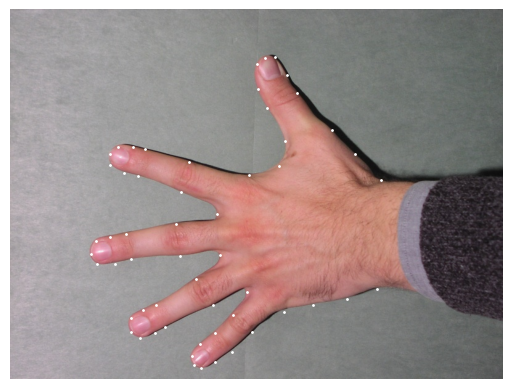

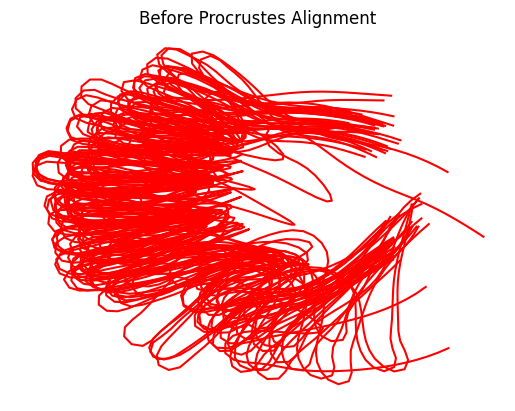

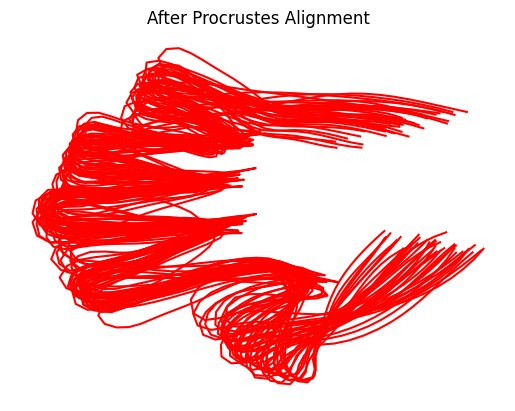

interactive(children=(FloatSlider(value=0.0, description='Alpha', max=3.0, step=0.01), Output()), _dom_classes…

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from ipywidgets import interactive
import ipywidgets as widgets

# Assuming the necessary helper functions are already defined (like showInterp, interp, etc.)
def make_1d(hand):
    if len(hand.shape) == 2:  # If hand is 2D
        return np.concatenate([hand[:, 0], hand[:, 1]]).reshape(-1)
    else:  # If hand is already 1D
        return hand

def unmake_1d(hand):
    if len(hand.shape) == 1:
        return np.array([[hand[i], hand[i + 56]] for i in range(0, hand.shape[0] // 2)])
    else:
        return hand

def update(alpha, normalized_hands, mean_hand, components, std_devs):
    # Clear the current plot
    plt.clf()

    # Create the hand based on the PCA mean and adjusted modes
    new_hand = make_1d(mean_hand.copy())  # Flatten the mean hand into 1D

    # Add the modes scaled by alpha * std_devs
    for i in range(components.shape[0]):
        new_hand += alpha * std_devs[i] * components[i]  # Adjusted mode

    # Reshape the 1D hand back to the 2D form
    reshaped_hand = unmake_1d(new_hand)

    # Plot the new hand
    fig, ax = plt.subplots(figsize=(8, 6))
    showInterp(interp(reshaped_hand))  # Interpolate and show
    ax.set_title(f"Generated Hand with Alpha={alpha:.2f}")
    plt.show()

def main():
    segmentationlist = readSegmentations(filepath, getxy)[0]
    hands = np.array(segmentationlist).T

    showSegImg(os.path.join(filepath, '0000.jpg'), unmake_1d(hands[0]), 600, 600)

    normalized_hands = procrustes_hand(hands)

    # Apply PCA using sklearn
    pca = PCA(n_components=5)  # Number of components for PCA
    # Flatten the hands for PCA, ensure each hand is a 1D array
    pca_result = pca.fit_transform(np.array([make_1d(hand) for hand in normalized_hands]))

    # Mean and components of the PCA
    mean_hand = np.mean(normalized_hands, axis=0)
    components = pca.components_
    std_devs = np.std(pca_result, axis=0)

    # Create an interactive widget
    interactive_plot = interactive(update,
                                   alpha=widgets.FloatSlider(value=0, min=0, max=3, step=0.01, description='Alpha'),
                                   normalized_hands=widgets.fixed(normalized_hands),
                                   mean_hand=widgets.fixed(mean_hand),
                                   components=widgets.fixed(components),
                                   std_devs=widgets.fixed(std_devs))

    # Display the interactive widget
    display(interactive_plot)

if __name__ == '__main__':
    main()


**Example Outputs:**

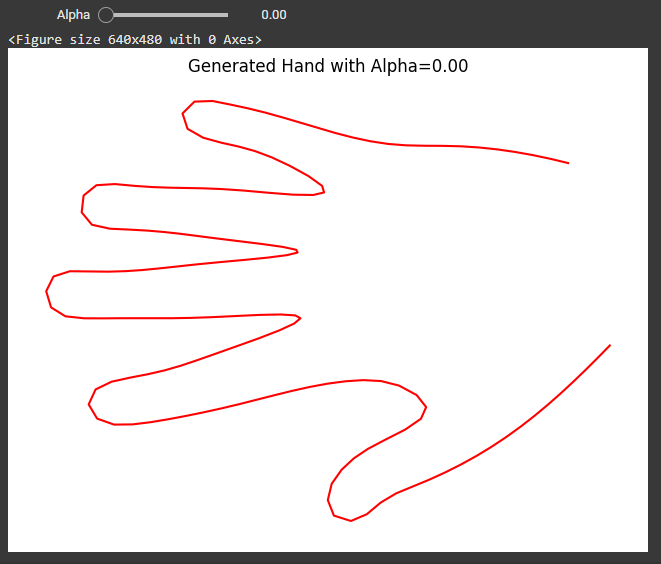

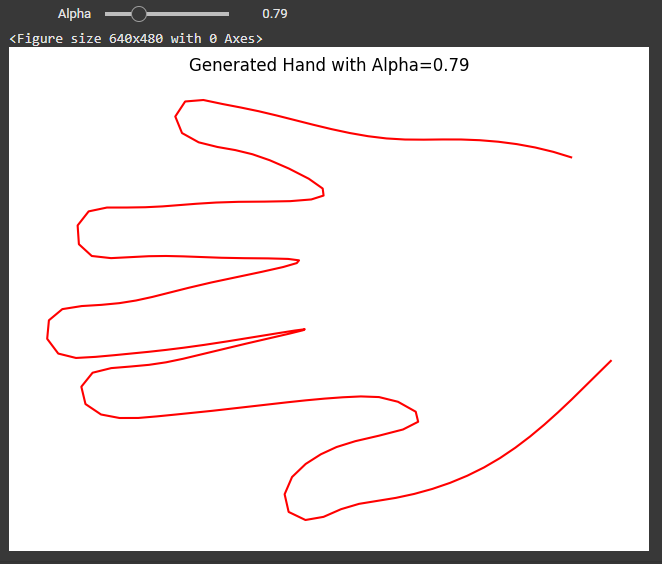

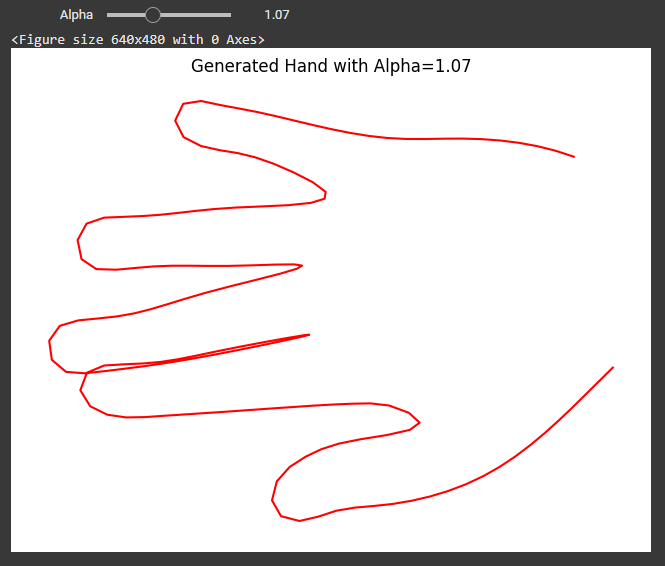